In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# loading the xtc and gro file into mdtraj
traj = md.load('../../../xtc_files/50000eql2.xtc', top='../../../xtc_files/conf.gro')

In [3]:
# converting traj as traj with only 5000 frames
traj=traj[::5]

In [4]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in tqdm(range(nframes)):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

100%|██████████| 10001/10001 [00:23<00:00, 417.12it/s]


(10001, 592, 3)


In [5]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in tqdm(range(nframes)):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

100%|██████████| 10001/10001 [1:06:42<00:00,  2.50it/s]

10001


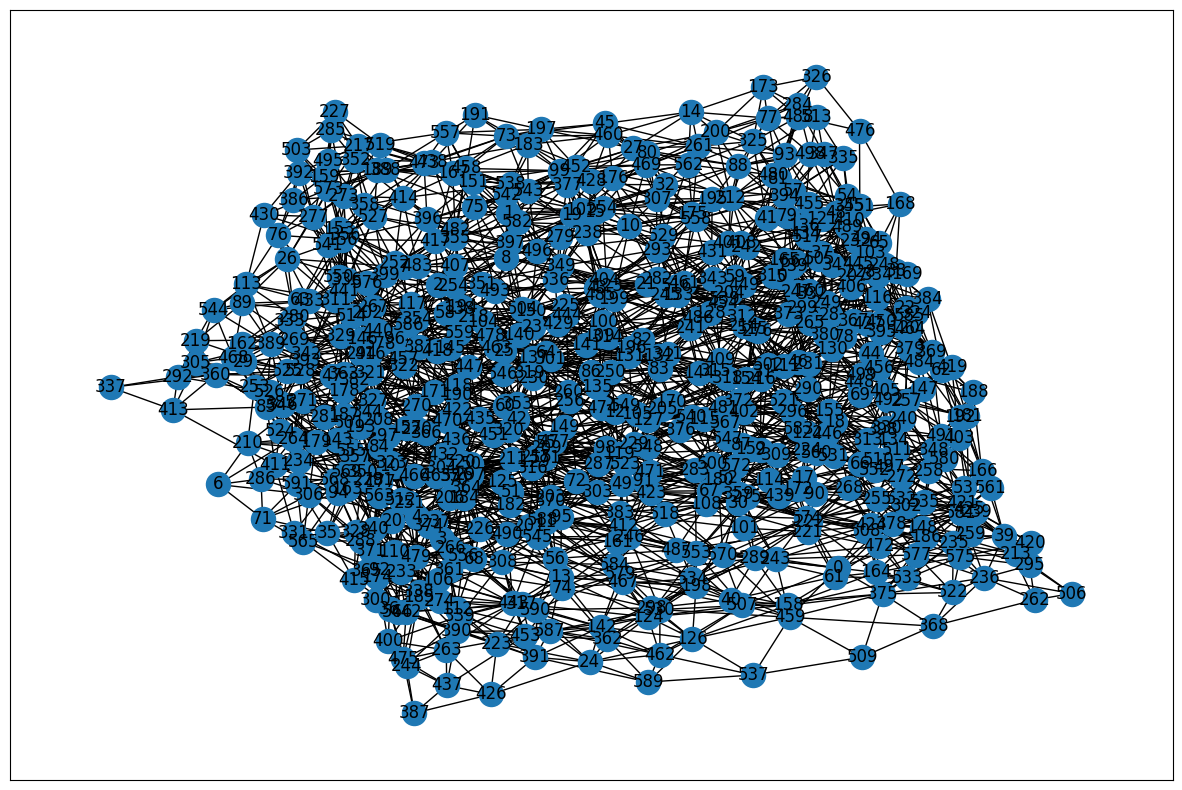

In [6]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [7]:
graphs = []
for frame in tqdm(range(nframes)):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

100%|██████████| 10001/10001 [00:00<00:00, 17887.81it/s]

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [8]:
# import model.
from model import *

In [9]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
from pytorch3d.loss import chamfer_distance

In [11]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [12]:
#for data in train_loader_set:
#    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
#    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
#    # print(data)
#    print(decodedx)
#    print("data.x")
#    print(data.x)
#    print("sizes")
#    print(decodedx.size())
#    print(data.x.size())

In [13]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [14]:
# writing a vakidation function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [15]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    type_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index= model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss+closs 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        

    return loss_all / len(test_loader_set.dataset), closs_all/len(test_loader_set.dataset),feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [16]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
val_total_losses = []
val_feature_losses = []
val_edge_losses = []
val_kl_losses = []
test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
cd_losses=[]
val_cd_losses=[]
test_cd_losses=[]
for epoch in tqdm(range(1, epochs+ 1)):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    val_total_loss, val_cd_loss,val_feature_loss, val_edge_loss, val_kl_loss = validate()
    test_total_loss, test_cd_loss,test_feature_loss, test_edge_loss, test_kl_loss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    print(f'VALIDATE : Total Loss: {val_total_loss:.4f}, CD Loss : {val_cd_loss:.4f},Feature Loss: {val_feature_loss:.4f}, Edge Loss: {val_edge_loss:.4f}')
    print(f'TEST : Total Loss: {test_total_loss:.4f},CD Loss : {test_cd_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    val_total_losses.append(val_total_loss)
    val_feature_losses.append(val_feature_loss)
    val_edge_losses.append(val_edge_loss)
    val_kl_losses.append(val_kl_loss)
    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    cd_losses.append(cd_loss)
    val_cd_losses.append(val_cd_loss)   
    test_cd_losses.append(test_cd_loss) 
    

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_5579/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_5579/368484634.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_5579/3817500453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
  1%|          | 1/100 [01:07<1:51:51, 67.79s/it]

Epoch: 001
TRAIN : Total Loss: 3.3031, CD Loss : 2.2801, Feature Loss: 1.0229, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.9800, CD Loss : 0.6704,Feature Loss: 0.3096, Edge Loss: 0.0000
TEST : Total Loss: 0.9800,CD Loss : 0.6707, Feature Loss: 0.3092, Edge Loss: 0.0000


  2%|▏         | 2/100 [02:25<1:59:55, 73.42s/it]

Epoch: 002
TRAIN : Total Loss: 0.8846, CD Loss : 0.6183, Feature Loss: 0.2663, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8356, CD Loss : 0.5988,Feature Loss: 0.2368, Edge Loss: 0.0000
TEST : Total Loss: 0.8353,CD Loss : 0.5988, Feature Loss: 0.2365, Edge Loss: 0.0000


  3%|▎         | 3/100 [03:58<2:13:10, 82.38s/it]

Epoch: 003
TRAIN : Total Loss: 0.8154, CD Loss : 0.5849, Feature Loss: 0.2305, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8003, CD Loss : 0.5767,Feature Loss: 0.2236, Edge Loss: 0.0000
TEST : Total Loss: 0.8002,CD Loss : 0.5768, Feature Loss: 0.2234, Edge Loss: 0.0000


  4%|▍         | 4/100 [05:33<2:19:58, 87.49s/it]

Epoch: 004
TRAIN : Total Loss: 0.7880, CD Loss : 0.5681, Feature Loss: 0.2200, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7650, CD Loss : 0.5496,Feature Loss: 0.2154, Edge Loss: 0.0000
TEST : Total Loss: 0.7648,CD Loss : 0.5495, Feature Loss: 0.2153, Edge Loss: 0.0000


  5%|▌         | 5/100 [06:43<2:08:21, 81.07s/it]

Epoch: 005
TRAIN : Total Loss: 0.7165, CD Loss : 0.5074, Feature Loss: 0.2091, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.6707, CD Loss : 0.4684,Feature Loss: 0.2023, Edge Loss: 0.0000
TEST : Total Loss: 0.6710,CD Loss : 0.4685, Feature Loss: 0.2024, Edge Loss: 0.0000


  6%|▌         | 6/100 [08:02<2:05:52, 80.35s/it]

Epoch: 006
TRAIN : Total Loss: 0.6383, CD Loss : 0.4441, Feature Loss: 0.1942, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.5898, CD Loss : 0.4063,Feature Loss: 0.1834, Edge Loss: 0.0000
TEST : Total Loss: 0.5907,CD Loss : 0.4068, Feature Loss: 0.1838, Edge Loss: 0.0000


  7%|▋         | 7/100 [09:13<2:00:01, 77.44s/it]

Epoch: 007
TRAIN : Total Loss: 0.5162, CD Loss : 0.3494, Feature Loss: 0.1668, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4672, CD Loss : 0.3133,Feature Loss: 0.1539, Edge Loss: 0.0000
TEST : Total Loss: 0.4682,CD Loss : 0.3139, Feature Loss: 0.1543, Edge Loss: 0.0000


  8%|▊         | 8/100 [10:31<1:59:07, 77.69s/it]

Epoch: 008
TRAIN : Total Loss: 0.4531, CD Loss : 0.3031, Feature Loss: 0.1500, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4442, CD Loss : 0.2972,Feature Loss: 0.1471, Edge Loss: 0.0000
TEST : Total Loss: 0.4452,CD Loss : 0.2977, Feature Loss: 0.1475, Edge Loss: 0.0000


  9%|▉         | 9/100 [11:44<1:55:36, 76.22s/it]

Epoch: 009
TRAIN : Total Loss: 0.4352, CD Loss : 0.2902, Feature Loss: 0.1450, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4243, CD Loss : 0.2818,Feature Loss: 0.1425, Edge Loss: 0.0000
TEST : Total Loss: 0.4253,CD Loss : 0.2824, Feature Loss: 0.1429, Edge Loss: 0.0000


 10%|█         | 10/100 [12:50<1:49:15, 72.84s/it]

Epoch: 010
TRAIN : Total Loss: 0.4100, CD Loss : 0.2701, Feature Loss: 0.1399, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3937, CD Loss : 0.2568,Feature Loss: 0.1368, Edge Loss: 0.0000
TEST : Total Loss: 0.3947,CD Loss : 0.2574, Feature Loss: 0.1372, Edge Loss: 0.0000


 11%|█         | 11/100 [14:24<1:57:47, 79.41s/it]

Epoch: 011
TRAIN : Total Loss: 0.3772, CD Loss : 0.2432, Feature Loss: 0.1340, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3608, CD Loss : 0.2297,Feature Loss: 0.1311, Edge Loss: 0.0000
TEST : Total Loss: 0.3616,CD Loss : 0.2302, Feature Loss: 0.1314, Edge Loss: 0.0000


 12%|█▏        | 12/100 [15:50<1:59:24, 81.41s/it]

Epoch: 012
TRAIN : Total Loss: 0.3511, CD Loss : 0.2226, Feature Loss: 0.1285, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3422, CD Loss : 0.2163,Feature Loss: 0.1260, Edge Loss: 0.0000
TEST : Total Loss: 0.3427,CD Loss : 0.2167, Feature Loss: 0.1261, Edge Loss: 0.0000


 13%|█▎        | 13/100 [17:00<1:53:05, 77.99s/it]

Epoch: 013
TRAIN : Total Loss: 0.3353, CD Loss : 0.2119, Feature Loss: 0.1234, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3301, CD Loss : 0.2088,Feature Loss: 0.1213, Edge Loss: 0.0000
TEST : Total Loss: 0.3305,CD Loss : 0.2092, Feature Loss: 0.1213, Edge Loss: 0.0000


 14%|█▍        | 14/100 [18:07<1:46:56, 74.61s/it]

Epoch: 014
TRAIN : Total Loss: 0.3253, CD Loss : 0.2060, Feature Loss: 0.1193, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3216, CD Loss : 0.2038,Feature Loss: 0.1178, Edge Loss: 0.0000
TEST : Total Loss: 0.3220,CD Loss : 0.2042, Feature Loss: 0.1178, Edge Loss: 0.0000


 15%|█▌        | 15/100 [19:21<1:45:42, 74.62s/it]

Epoch: 015
TRAIN : Total Loss: 0.3177, CD Loss : 0.2014, Feature Loss: 0.1163, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3149, CD Loss : 0.1997,Feature Loss: 0.1152, Edge Loss: 0.0000
TEST : Total Loss: 0.3153,CD Loss : 0.2001, Feature Loss: 0.1153, Edge Loss: 0.0000


 16%|█▌        | 16/100 [20:35<1:44:05, 74.35s/it]

Epoch: 016
TRAIN : Total Loss: 0.3112, CD Loss : 0.1971, Feature Loss: 0.1141, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3078, CD Loss : 0.1945,Feature Loss: 0.1134, Edge Loss: 0.0000
TEST : Total Loss: 0.3082,CD Loss : 0.1949, Feature Loss: 0.1133, Edge Loss: 0.0000


 17%|█▋        | 17/100 [21:55<1:45:00, 75.91s/it]

Epoch: 017
TRAIN : Total Loss: 0.3052, CD Loss : 0.1928, Feature Loss: 0.1124, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3029, CD Loss : 0.1912,Feature Loss: 0.1118, Edge Loss: 0.0000
TEST : Total Loss: 0.3033,CD Loss : 0.1915, Feature Loss: 0.1118, Edge Loss: 0.0000


 18%|█▊        | 18/100 [23:04<1:41:02, 73.94s/it]

Epoch: 018
TRAIN : Total Loss: 0.3001, CD Loss : 0.1890, Feature Loss: 0.1110, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2978, CD Loss : 0.1872,Feature Loss: 0.1106, Edge Loss: 0.0000
TEST : Total Loss: 0.2981,CD Loss : 0.1876, Feature Loss: 0.1106, Edge Loss: 0.0000


 19%|█▉        | 19/100 [24:14<1:38:18, 72.82s/it]

Epoch: 019
TRAIN : Total Loss: 0.2957, CD Loss : 0.1858, Feature Loss: 0.1099, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2937, CD Loss : 0.1842,Feature Loss: 0.1095, Edge Loss: 0.0000
TEST : Total Loss: 0.2940,CD Loss : 0.1845, Feature Loss: 0.1094, Edge Loss: 0.0000


 20%|██        | 20/100 [25:21<1:34:35, 70.94s/it]

Epoch: 020
TRAIN : Total Loss: 0.2919, CD Loss : 0.1830, Feature Loss: 0.1089, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2900, CD Loss : 0.1815,Feature Loss: 0.1085, Edge Loss: 0.0000
TEST : Total Loss: 0.2904,CD Loss : 0.1818, Feature Loss: 0.1085, Edge Loss: 0.0000


 21%|██        | 21/100 [26:32<1:33:34, 71.07s/it]

Epoch: 021
TRAIN : Total Loss: 0.2886, CD Loss : 0.1806, Feature Loss: 0.1080, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2871, CD Loss : 0.1795,Feature Loss: 0.1077, Edge Loss: 0.0000
TEST : Total Loss: 0.2874,CD Loss : 0.1798, Feature Loss: 0.1076, Edge Loss: 0.0000


 22%|██▏       | 22/100 [27:44<1:32:42, 71.31s/it]

Epoch: 022
TRAIN : Total Loss: 0.2855, CD Loss : 0.1784, Feature Loss: 0.1072, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2841, CD Loss : 0.1772,Feature Loss: 0.1069, Edge Loss: 0.0000
TEST : Total Loss: 0.2844,CD Loss : 0.1775, Feature Loss: 0.1069, Edge Loss: 0.0000


 23%|██▎       | 23/100 [29:10<1:37:19, 75.84s/it]

Epoch: 023
TRAIN : Total Loss: 0.2827, CD Loss : 0.1763, Feature Loss: 0.1064, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2805, CD Loss : 0.1744,Feature Loss: 0.1061, Edge Loss: 0.0000
TEST : Total Loss: 0.2809,CD Loss : 0.1748, Feature Loss: 0.1061, Edge Loss: 0.0000


 24%|██▍       | 24/100 [30:25<1:35:39, 75.53s/it]

Epoch: 024
TRAIN : Total Loss: 0.2800, CD Loss : 0.1743, Feature Loss: 0.1057, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2785, CD Loss : 0.1731,Feature Loss: 0.1054, Edge Loss: 0.0000
TEST : Total Loss: 0.2788,CD Loss : 0.1734, Feature Loss: 0.1054, Edge Loss: 0.0000


 25%|██▌       | 25/100 [31:32<1:31:08, 72.91s/it]

Epoch: 025
TRAIN : Total Loss: 0.2774, CD Loss : 0.1724, Feature Loss: 0.1050, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2774, CD Loss : 0.1726,Feature Loss: 0.1048, Edge Loss: 0.0000
TEST : Total Loss: 0.2778,CD Loss : 0.1730, Feature Loss: 0.1047, Edge Loss: 0.0000


 26%|██▌       | 26/100 [32:38<1:27:14, 70.73s/it]

Epoch: 026
TRAIN : Total Loss: 0.2750, CD Loss : 0.1707, Feature Loss: 0.1043, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2741, CD Loss : 0.1700,Feature Loss: 0.1041, Edge Loss: 0.0000
TEST : Total Loss: 0.2744,CD Loss : 0.1703, Feature Loss: 0.1040, Edge Loss: 0.0000


 27%|██▋       | 27/100 [33:43<1:24:04, 69.10s/it]

Epoch: 027
TRAIN : Total Loss: 0.2726, CD Loss : 0.1689, Feature Loss: 0.1037, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2715, CD Loss : 0.1680,Feature Loss: 0.1034, Edge Loss: 0.0000
TEST : Total Loss: 0.2718,CD Loss : 0.1684, Feature Loss: 0.1034, Edge Loss: 0.0000


 28%|██▊       | 28/100 [34:53<1:23:23, 69.49s/it]

Epoch: 028
TRAIN : Total Loss: 0.2704, CD Loss : 0.1674, Feature Loss: 0.1031, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2689, CD Loss : 0.1660,Feature Loss: 0.1029, Edge Loss: 0.0000
TEST : Total Loss: 0.2692,CD Loss : 0.1664, Feature Loss: 0.1028, Edge Loss: 0.0000


 29%|██▉       | 29/100 [36:02<1:22:03, 69.34s/it]

Epoch: 029
TRAIN : Total Loss: 0.2683, CD Loss : 0.1659, Feature Loss: 0.1025, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2670, CD Loss : 0.1647,Feature Loss: 0.1023, Edge Loss: 0.0000
TEST : Total Loss: 0.2673,CD Loss : 0.1650, Feature Loss: 0.1023, Edge Loss: 0.0000


 30%|███       | 30/100 [37:07<1:19:22, 68.03s/it]

Epoch: 030
TRAIN : Total Loss: 0.2664, CD Loss : 0.1644, Feature Loss: 0.1019, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2661, CD Loss : 0.1643,Feature Loss: 0.1018, Edge Loss: 0.0000
TEST : Total Loss: 0.2664,CD Loss : 0.1646, Feature Loss: 0.1018, Edge Loss: 0.0000


 31%|███       | 31/100 [38:25<1:21:28, 70.85s/it]

Epoch: 031
TRAIN : Total Loss: 0.2646, CD Loss : 0.1631, Feature Loss: 0.1014, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2642, CD Loss : 0.1629,Feature Loss: 0.1013, Edge Loss: 0.0000
TEST : Total Loss: 0.2645,CD Loss : 0.1633, Feature Loss: 0.1013, Edge Loss: 0.0000


 32%|███▏      | 32/100 [39:46<1:23:39, 73.82s/it]

Epoch: 032
TRAIN : Total Loss: 0.2628, CD Loss : 0.1619, Feature Loss: 0.1009, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2621, CD Loss : 0.1613,Feature Loss: 0.1008, Edge Loss: 0.0000
TEST : Total Loss: 0.2624,CD Loss : 0.1616, Feature Loss: 0.1008, Edge Loss: 0.0000


 33%|███▎      | 33/100 [40:52<1:19:57, 71.60s/it]

Epoch: 033
TRAIN : Total Loss: 0.2612, CD Loss : 0.1607, Feature Loss: 0.1005, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2610, CD Loss : 0.1606,Feature Loss: 0.1004, Edge Loss: 0.0000
TEST : Total Loss: 0.2612,CD Loss : 0.1609, Feature Loss: 0.1003, Edge Loss: 0.0000


 34%|███▍      | 34/100 [42:03<1:18:34, 71.42s/it]

Epoch: 034
TRAIN : Total Loss: 0.2598, CD Loss : 0.1597, Feature Loss: 0.1001, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2591, CD Loss : 0.1591,Feature Loss: 0.1000, Edge Loss: 0.0000
TEST : Total Loss: 0.2594,CD Loss : 0.1594, Feature Loss: 0.1000, Edge Loss: 0.0000


 35%|███▌      | 35/100 [43:12<1:16:29, 70.61s/it]

Epoch: 035
TRAIN : Total Loss: 0.2584, CD Loss : 0.1587, Feature Loss: 0.0997, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2590, CD Loss : 0.1593,Feature Loss: 0.0997, Edge Loss: 0.0000
TEST : Total Loss: 0.2593,CD Loss : 0.1597, Feature Loss: 0.0996, Edge Loss: 0.0000


 36%|███▌      | 36/100 [44:17<1:13:40, 69.06s/it]

Epoch: 036
TRAIN : Total Loss: 0.2571, CD Loss : 0.1578, Feature Loss: 0.0993, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2569, CD Loss : 0.1575,Feature Loss: 0.0993, Edge Loss: 0.0000
TEST : Total Loss: 0.2570,CD Loss : 0.1578, Feature Loss: 0.0992, Edge Loss: 0.0000


 37%|███▋      | 37/100 [45:45<1:18:23, 74.65s/it]

Epoch: 037
TRAIN : Total Loss: 0.2559, CD Loss : 0.1569, Feature Loss: 0.0990, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2553, CD Loss : 0.1563,Feature Loss: 0.0990, Edge Loss: 0.0000
TEST : Total Loss: 0.2555,CD Loss : 0.1565, Feature Loss: 0.0989, Edge Loss: 0.0000


 38%|███▊      | 38/100 [46:52<1:14:56, 72.53s/it]

Epoch: 038
TRAIN : Total Loss: 0.2547, CD Loss : 0.1560, Feature Loss: 0.0987, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2553, CD Loss : 0.1566,Feature Loss: 0.0987, Edge Loss: 0.0000
TEST : Total Loss: 0.2555,CD Loss : 0.1569, Feature Loss: 0.0986, Edge Loss: 0.0000


 39%|███▉      | 39/100 [48:20<1:18:15, 76.97s/it]

Epoch: 039
TRAIN : Total Loss: 0.2537, CD Loss : 0.1553, Feature Loss: 0.0984, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2547, CD Loss : 0.1563,Feature Loss: 0.0984, Edge Loss: 0.0000
TEST : Total Loss: 0.2549,CD Loss : 0.1566, Feature Loss: 0.0983, Edge Loss: 0.0000


 40%|████      | 40/100 [49:25<1:13:24, 73.41s/it]

Epoch: 040
TRAIN : Total Loss: 0.2526, CD Loss : 0.1545, Feature Loss: 0.0981, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2526, CD Loss : 0.1545,Feature Loss: 0.0981, Edge Loss: 0.0000
TEST : Total Loss: 0.2528,CD Loss : 0.1548, Feature Loss: 0.0980, Edge Loss: 0.0000


 41%|████      | 41/100 [50:50<1:15:31, 76.80s/it]

Epoch: 041
TRAIN : Total Loss: 0.2516, CD Loss : 0.1538, Feature Loss: 0.0978, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2509, CD Loss : 0.1530,Feature Loss: 0.0979, Edge Loss: 0.0000
TEST : Total Loss: 0.2511,CD Loss : 0.1533, Feature Loss: 0.0978, Edge Loss: 0.0000


 42%|████▏     | 42/100 [51:58<1:11:48, 74.29s/it]

Epoch: 042
TRAIN : Total Loss: 0.2506, CD Loss : 0.1530, Feature Loss: 0.0976, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2515, CD Loss : 0.1538,Feature Loss: 0.0977, Edge Loss: 0.0000
TEST : Total Loss: 0.2517,CD Loss : 0.1541, Feature Loss: 0.0976, Edge Loss: 0.0000


 43%|████▎     | 43/100 [53:04<1:08:04, 71.66s/it]

Epoch: 043
TRAIN : Total Loss: 0.2497, CD Loss : 0.1524, Feature Loss: 0.0973, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2493, CD Loss : 0.1519,Feature Loss: 0.0974, Edge Loss: 0.0000
TEST : Total Loss: 0.2494,CD Loss : 0.1521, Feature Loss: 0.0973, Edge Loss: 0.0000


 44%|████▍     | 44/100 [54:37<1:12:59, 78.20s/it]

Epoch: 044
TRAIN : Total Loss: 0.2488, CD Loss : 0.1516, Feature Loss: 0.0971, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2488, CD Loss : 0.1517,Feature Loss: 0.0972, Edge Loss: 0.0000
TEST : Total Loss: 0.2490,CD Loss : 0.1519, Feature Loss: 0.0971, Edge Loss: 0.0000


 45%|████▌     | 45/100 [55:48<1:09:46, 76.12s/it]

Epoch: 045
TRAIN : Total Loss: 0.2479, CD Loss : 0.1510, Feature Loss: 0.0969, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2468, CD Loss : 0.1499,Feature Loss: 0.0970, Edge Loss: 0.0000
TEST : Total Loss: 0.2469,CD Loss : 0.1501, Feature Loss: 0.0968, Edge Loss: 0.0000


 46%|████▌     | 46/100 [57:04<1:08:27, 76.07s/it]

Epoch: 046
TRAIN : Total Loss: 0.2469, CD Loss : 0.1503, Feature Loss: 0.0967, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2463, CD Loss : 0.1496,Feature Loss: 0.0967, Edge Loss: 0.0000
TEST : Total Loss: 0.2464,CD Loss : 0.1498, Feature Loss: 0.0966, Edge Loss: 0.0000


 47%|████▋     | 47/100 [58:11<1:04:44, 73.29s/it]

Epoch: 047
TRAIN : Total Loss: 0.2460, CD Loss : 0.1496, Feature Loss: 0.0964, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2457, CD Loss : 0.1492,Feature Loss: 0.0965, Edge Loss: 0.0000
TEST : Total Loss: 0.2458,CD Loss : 0.1494, Feature Loss: 0.0964, Edge Loss: 0.0000


 48%|████▊     | 48/100 [59:22<1:03:00, 72.70s/it]

Epoch: 048
TRAIN : Total Loss: 0.2451, CD Loss : 0.1489, Feature Loss: 0.0962, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2452, CD Loss : 0.1489,Feature Loss: 0.0963, Edge Loss: 0.0000
TEST : Total Loss: 0.2453,CD Loss : 0.1491, Feature Loss: 0.0962, Edge Loss: 0.0000


 49%|████▉     | 49/100 [1:00:42<1:03:27, 74.66s/it]

Epoch: 049
TRAIN : Total Loss: 0.2443, CD Loss : 0.1483, Feature Loss: 0.0960, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2445, CD Loss : 0.1484,Feature Loss: 0.0961, Edge Loss: 0.0000
TEST : Total Loss: 0.2446,CD Loss : 0.1487, Feature Loss: 0.0959, Edge Loss: 0.0000


 50%|█████     | 50/100 [1:01:53<1:01:21, 73.63s/it]

Epoch: 050
TRAIN : Total Loss: 0.2434, CD Loss : 0.1476, Feature Loss: 0.0958, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2432, CD Loss : 0.1473,Feature Loss: 0.0959, Edge Loss: 0.0000
TEST : Total Loss: 0.2433,CD Loss : 0.1475, Feature Loss: 0.0958, Edge Loss: 0.0000


 51%|█████     | 51/100 [1:02:58<58:10, 71.23s/it]  

Epoch: 051
TRAIN : Total Loss: 0.2425, CD Loss : 0.1469, Feature Loss: 0.0956, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2419, CD Loss : 0.1463,Feature Loss: 0.0957, Edge Loss: 0.0000
TEST : Total Loss: 0.2420,CD Loss : 0.1465, Feature Loss: 0.0955, Edge Loss: 0.0000


 52%|█████▏    | 52/100 [1:04:22<59:53, 74.86s/it]

Epoch: 052
TRAIN : Total Loss: 0.2417, CD Loss : 0.1463, Feature Loss: 0.0954, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2411, CD Loss : 0.1457,Feature Loss: 0.0955, Edge Loss: 0.0000
TEST : Total Loss: 0.2412,CD Loss : 0.1458, Feature Loss: 0.0953, Edge Loss: 0.0000


 53%|█████▎    | 53/100 [1:05:28<56:40, 72.35s/it]

Epoch: 053
TRAIN : Total Loss: 0.2408, CD Loss : 0.1457, Feature Loss: 0.0952, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2410, CD Loss : 0.1458,Feature Loss: 0.0952, Edge Loss: 0.0000
TEST : Total Loss: 0.2411,CD Loss : 0.1460, Feature Loss: 0.0951, Edge Loss: 0.0000


 54%|█████▍    | 54/100 [1:06:35<54:04, 70.54s/it]

Epoch: 054
TRAIN : Total Loss: 0.2401, CD Loss : 0.1451, Feature Loss: 0.0950, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2386, CD Loss : 0.1435,Feature Loss: 0.0951, Edge Loss: 0.0000
TEST : Total Loss: 0.2386,CD Loss : 0.1436, Feature Loss: 0.0950, Edge Loss: 0.0000


 55%|█████▌    | 55/100 [1:07:46<53:10, 70.91s/it]

Epoch: 055
TRAIN : Total Loss: 0.2392, CD Loss : 0.1444, Feature Loss: 0.0948, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2389, CD Loss : 0.1441,Feature Loss: 0.0948, Edge Loss: 0.0000
TEST : Total Loss: 0.2390,CD Loss : 0.1443, Feature Loss: 0.0947, Edge Loss: 0.0000


 56%|█████▌    | 56/100 [1:09:26<58:20, 79.56s/it]

Epoch: 056
TRAIN : Total Loss: 0.2385, CD Loss : 0.1439, Feature Loss: 0.0946, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2389, CD Loss : 0.1442,Feature Loss: 0.0947, Edge Loss: 0.0000
TEST : Total Loss: 0.2389,CD Loss : 0.1444, Feature Loss: 0.0945, Edge Loss: 0.0000


 57%|█████▋    | 57/100 [1:10:49<57:45, 80.59s/it]

Epoch: 057
TRAIN : Total Loss: 0.2377, CD Loss : 0.1433, Feature Loss: 0.0944, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2374, CD Loss : 0.1429,Feature Loss: 0.0945, Edge Loss: 0.0000
TEST : Total Loss: 0.2374,CD Loss : 0.1431, Feature Loss: 0.0943, Edge Loss: 0.0000


 58%|█████▊    | 58/100 [1:12:32<1:01:07, 87.33s/it]

Epoch: 058
TRAIN : Total Loss: 0.2369, CD Loss : 0.1427, Feature Loss: 0.0942, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2380, CD Loss : 0.1437,Feature Loss: 0.0943, Edge Loss: 0.0000
TEST : Total Loss: 0.2381,CD Loss : 0.1439, Feature Loss: 0.0942, Edge Loss: 0.0000


 59%|█████▉    | 59/100 [1:13:39<55:28, 81.19s/it]  

Epoch: 059
TRAIN : Total Loss: 0.2362, CD Loss : 0.1422, Feature Loss: 0.0940, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2355, CD Loss : 0.1413,Feature Loss: 0.0941, Edge Loss: 0.0000
TEST : Total Loss: 0.2355,CD Loss : 0.1415, Feature Loss: 0.0940, Edge Loss: 0.0000


 60%|██████    | 60/100 [1:14:46<51:15, 76.89s/it]

Epoch: 060
TRAIN : Total Loss: 0.2355, CD Loss : 0.1416, Feature Loss: 0.0938, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2364, CD Loss : 0.1424,Feature Loss: 0.0939, Edge Loss: 0.0000
TEST : Total Loss: 0.2364,CD Loss : 0.1426, Feature Loss: 0.0938, Edge Loss: 0.0000


 61%|██████    | 61/100 [1:15:52<47:55, 73.74s/it]

Epoch: 061
TRAIN : Total Loss: 0.2348, CD Loss : 0.1412, Feature Loss: 0.0937, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2347, CD Loss : 0.1410,Feature Loss: 0.0938, Edge Loss: 0.0000
TEST : Total Loss: 0.2347,CD Loss : 0.1411, Feature Loss: 0.0936, Edge Loss: 0.0000


 62%|██████▏   | 62/100 [1:17:29<51:08, 80.75s/it]

Epoch: 062
TRAIN : Total Loss: 0.2342, CD Loss : 0.1407, Feature Loss: 0.0935, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2346, CD Loss : 0.1410,Feature Loss: 0.0936, Edge Loss: 0.0000
TEST : Total Loss: 0.2346,CD Loss : 0.1412, Feature Loss: 0.0934, Edge Loss: 0.0000


 63%|██████▎   | 63/100 [1:19:23<55:52, 90.62s/it]

Epoch: 063
TRAIN : Total Loss: 0.2335, CD Loss : 0.1402, Feature Loss: 0.0933, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2334, CD Loss : 0.1399,Feature Loss: 0.0934, Edge Loss: 0.0000
TEST : Total Loss: 0.2333,CD Loss : 0.1401, Feature Loss: 0.0933, Edge Loss: 0.0000


 64%|██████▍   | 64/100 [1:20:34<50:48, 84.69s/it]

Epoch: 064
TRAIN : Total Loss: 0.2329, CD Loss : 0.1398, Feature Loss: 0.0932, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2335, CD Loss : 0.1402,Feature Loss: 0.0932, Edge Loss: 0.0000
TEST : Total Loss: 0.2335,CD Loss : 0.1404, Feature Loss: 0.0931, Edge Loss: 0.0000


 65%|██████▌   | 65/100 [1:22:00<49:43, 85.24s/it]

Epoch: 065
TRAIN : Total Loss: 0.2323, CD Loss : 0.1393, Feature Loss: 0.0930, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2328, CD Loss : 0.1396,Feature Loss: 0.0932, Edge Loss: 0.0000
TEST : Total Loss: 0.2328,CD Loss : 0.1398, Feature Loss: 0.0930, Edge Loss: 0.0000


 66%|██████▌   | 66/100 [1:23:07<45:07, 79.62s/it]

Epoch: 066
TRAIN : Total Loss: 0.2317, CD Loss : 0.1389, Feature Loss: 0.0928, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2325, CD Loss : 0.1396,Feature Loss: 0.0929, Edge Loss: 0.0000
TEST : Total Loss: 0.2326,CD Loss : 0.1398, Feature Loss: 0.0928, Edge Loss: 0.0000


 67%|██████▋   | 67/100 [1:24:19<42:35, 77.45s/it]

Epoch: 067
TRAIN : Total Loss: 0.2312, CD Loss : 0.1385, Feature Loss: 0.0927, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2314, CD Loss : 0.1386,Feature Loss: 0.0928, Edge Loss: 0.0000
TEST : Total Loss: 0.2314,CD Loss : 0.1388, Feature Loss: 0.0926, Edge Loss: 0.0000


 68%|██████▊   | 68/100 [1:25:26<39:36, 74.25s/it]

Epoch: 068
TRAIN : Total Loss: 0.2306, CD Loss : 0.1381, Feature Loss: 0.0925, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2310, CD Loss : 0.1384,Feature Loss: 0.0926, Edge Loss: 0.0000
TEST : Total Loss: 0.2310,CD Loss : 0.1386, Feature Loss: 0.0925, Edge Loss: 0.0000


 69%|██████▉   | 69/100 [1:26:31<36:54, 71.44s/it]

Epoch: 069
TRAIN : Total Loss: 0.2301, CD Loss : 0.1377, Feature Loss: 0.0924, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2298, CD Loss : 0.1373,Feature Loss: 0.0925, Edge Loss: 0.0000
TEST : Total Loss: 0.2298,CD Loss : 0.1375, Feature Loss: 0.0923, Edge Loss: 0.0000


 70%|███████   | 70/100 [1:27:52<37:11, 74.39s/it]

Epoch: 070
TRAIN : Total Loss: 0.2296, CD Loss : 0.1374, Feature Loss: 0.0923, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2298, CD Loss : 0.1374,Feature Loss: 0.0924, Edge Loss: 0.0000
TEST : Total Loss: 0.2298,CD Loss : 0.1376, Feature Loss: 0.0922, Edge Loss: 0.0000


 71%|███████   | 71/100 [1:29:05<35:43, 73.90s/it]

Epoch: 071
TRAIN : Total Loss: 0.2292, CD Loss : 0.1370, Feature Loss: 0.0921, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2295, CD Loss : 0.1372,Feature Loss: 0.0922, Edge Loss: 0.0000
TEST : Total Loss: 0.2295,CD Loss : 0.1374, Feature Loss: 0.0921, Edge Loss: 0.0000


 72%|███████▏  | 72/100 [1:30:11<33:26, 71.65s/it]

Epoch: 072
TRAIN : Total Loss: 0.2287, CD Loss : 0.1367, Feature Loss: 0.0920, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2287, CD Loss : 0.1366,Feature Loss: 0.0921, Edge Loss: 0.0000
TEST : Total Loss: 0.2287,CD Loss : 0.1367, Feature Loss: 0.0919, Edge Loss: 0.0000


 73%|███████▎  | 73/100 [1:31:18<31:35, 70.22s/it]

Epoch: 073
TRAIN : Total Loss: 0.2283, CD Loss : 0.1364, Feature Loss: 0.0919, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2280, CD Loss : 0.1360,Feature Loss: 0.0920, Edge Loss: 0.0000
TEST : Total Loss: 0.2280,CD Loss : 0.1361, Feature Loss: 0.0919, Edge Loss: 0.0000


 74%|███████▍  | 74/100 [1:32:29<30:28, 70.32s/it]

Epoch: 074
TRAIN : Total Loss: 0.2279, CD Loss : 0.1361, Feature Loss: 0.0918, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2281, CD Loss : 0.1362,Feature Loss: 0.0919, Edge Loss: 0.0000
TEST : Total Loss: 0.2281,CD Loss : 0.1364, Feature Loss: 0.0917, Edge Loss: 0.0000


 75%|███████▌  | 75/100 [1:34:00<31:55, 76.61s/it]

Epoch: 075
TRAIN : Total Loss: 0.2275, CD Loss : 0.1358, Feature Loss: 0.0917, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2280, CD Loss : 0.1363,Feature Loss: 0.0918, Edge Loss: 0.0000
TEST : Total Loss: 0.2280,CD Loss : 0.1364, Feature Loss: 0.0916, Edge Loss: 0.0000


 76%|███████▌  | 76/100 [1:35:14<30:15, 75.65s/it]

Epoch: 076
TRAIN : Total Loss: 0.2271, CD Loss : 0.1356, Feature Loss: 0.0916, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2273, CD Loss : 0.1356,Feature Loss: 0.0917, Edge Loss: 0.0000
TEST : Total Loss: 0.2273,CD Loss : 0.1358, Feature Loss: 0.0915, Edge Loss: 0.0000


 77%|███████▋  | 77/100 [1:36:41<30:24, 79.34s/it]

Epoch: 077
TRAIN : Total Loss: 0.2268, CD Loss : 0.1354, Feature Loss: 0.0915, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2267, CD Loss : 0.1352,Feature Loss: 0.0916, Edge Loss: 0.0000
TEST : Total Loss: 0.2267,CD Loss : 0.1353, Feature Loss: 0.0914, Edge Loss: 0.0000


 78%|███████▊  | 78/100 [1:37:58<28:48, 78.55s/it]

Epoch: 078
TRAIN : Total Loss: 0.2265, CD Loss : 0.1351, Feature Loss: 0.0914, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2264, CD Loss : 0.1349,Feature Loss: 0.0915, Edge Loss: 0.0000
TEST : Total Loss: 0.2263,CD Loss : 0.1351, Feature Loss: 0.0913, Edge Loss: 0.0000


 79%|███████▉  | 79/100 [1:39:16<27:22, 78.21s/it]

Epoch: 079
TRAIN : Total Loss: 0.2262, CD Loss : 0.1349, Feature Loss: 0.0913, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2266, CD Loss : 0.1353,Feature Loss: 0.0914, Edge Loss: 0.0000
TEST : Total Loss: 0.2266,CD Loss : 0.1354, Feature Loss: 0.0912, Edge Loss: 0.0000


 80%|████████  | 80/100 [1:40:27<25:24, 76.23s/it]

Epoch: 080
TRAIN : Total Loss: 0.2259, CD Loss : 0.1347, Feature Loss: 0.0912, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2264, CD Loss : 0.1351,Feature Loss: 0.0913, Edge Loss: 0.0000
TEST : Total Loss: 0.2264,CD Loss : 0.1353, Feature Loss: 0.0911, Edge Loss: 0.0000


 81%|████████  | 81/100 [1:41:35<23:19, 73.67s/it]

Epoch: 081
TRAIN : Total Loss: 0.2256, CD Loss : 0.1345, Feature Loss: 0.0911, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2255, CD Loss : 0.1343,Feature Loss: 0.0912, Edge Loss: 0.0000
TEST : Total Loss: 0.2255,CD Loss : 0.1344, Feature Loss: 0.0911, Edge Loss: 0.0000


 82%|████████▏ | 82/100 [1:42:42<21:30, 71.67s/it]

Epoch: 082
TRAIN : Total Loss: 0.2254, CD Loss : 0.1343, Feature Loss: 0.0910, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2255, CD Loss : 0.1344,Feature Loss: 0.0912, Edge Loss: 0.0000
TEST : Total Loss: 0.2255,CD Loss : 0.1345, Feature Loss: 0.0910, Edge Loss: 0.0000


 83%|████████▎ | 83/100 [1:43:50<19:57, 70.46s/it]

Epoch: 083
TRAIN : Total Loss: 0.2251, CD Loss : 0.1342, Feature Loss: 0.0910, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2253, CD Loss : 0.1342,Feature Loss: 0.0911, Edge Loss: 0.0000
TEST : Total Loss: 0.2252,CD Loss : 0.1343, Feature Loss: 0.0909, Edge Loss: 0.0000


 84%|████████▍ | 84/100 [1:44:59<18:43, 70.19s/it]

Epoch: 084
TRAIN : Total Loss: 0.2249, CD Loss : 0.1340, Feature Loss: 0.0909, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2242, CD Loss : 0.1332,Feature Loss: 0.0910, Edge Loss: 0.0000
TEST : Total Loss: 0.2241,CD Loss : 0.1333, Feature Loss: 0.0908, Edge Loss: 0.0000


 85%|████████▌ | 85/100 [1:46:09<17:33, 70.22s/it]

Epoch: 085
TRAIN : Total Loss: 0.2247, CD Loss : 0.1338, Feature Loss: 0.0908, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2242, CD Loss : 0.1333,Feature Loss: 0.0910, Edge Loss: 0.0000
TEST : Total Loss: 0.2242,CD Loss : 0.1334, Feature Loss: 0.0908, Edge Loss: 0.0000


 86%|████████▌ | 86/100 [1:47:19<16:21, 70.13s/it]

Epoch: 086
TRAIN : Total Loss: 0.2245, CD Loss : 0.1337, Feature Loss: 0.0908, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2241, CD Loss : 0.1333,Feature Loss: 0.0909, Edge Loss: 0.0000
TEST : Total Loss: 0.2241,CD Loss : 0.1334, Feature Loss: 0.0907, Edge Loss: 0.0000


 87%|████████▋ | 87/100 [1:48:37<15:41, 72.42s/it]

Epoch: 087
TRAIN : Total Loss: 0.2243, CD Loss : 0.1336, Feature Loss: 0.0907, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2244, CD Loss : 0.1336,Feature Loss: 0.0908, Edge Loss: 0.0000
TEST : Total Loss: 0.2244,CD Loss : 0.1337, Feature Loss: 0.0906, Edge Loss: 0.0000


 88%|████████▊ | 88/100 [1:49:43<14:06, 70.55s/it]

Epoch: 088
TRAIN : Total Loss: 0.2241, CD Loss : 0.1334, Feature Loss: 0.0906, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2243, CD Loss : 0.1335,Feature Loss: 0.0907, Edge Loss: 0.0000
TEST : Total Loss: 0.2242,CD Loss : 0.1337, Feature Loss: 0.0906, Edge Loss: 0.0000


 89%|████████▉ | 89/100 [1:50:57<13:05, 71.45s/it]

Epoch: 089
TRAIN : Total Loss: 0.2239, CD Loss : 0.1333, Feature Loss: 0.0906, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2238, CD Loss : 0.1331,Feature Loss: 0.0907, Edge Loss: 0.0000
TEST : Total Loss: 0.2237,CD Loss : 0.1332, Feature Loss: 0.0905, Edge Loss: 0.0000


 90%|█████████ | 90/100 [1:52:05<11:45, 70.59s/it]

Epoch: 090
TRAIN : Total Loss: 0.2237, CD Loss : 0.1332, Feature Loss: 0.0905, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2242, CD Loss : 0.1336,Feature Loss: 0.0906, Edge Loss: 0.0000
TEST : Total Loss: 0.2242,CD Loss : 0.1337, Feature Loss: 0.0905, Edge Loss: 0.0000


 91%|█████████ | 91/100 [1:53:24<10:55, 72.88s/it]

Epoch: 091
TRAIN : Total Loss: 0.2236, CD Loss : 0.1331, Feature Loss: 0.0905, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2239, CD Loss : 0.1333,Feature Loss: 0.0906, Edge Loss: 0.0000
TEST : Total Loss: 0.2238,CD Loss : 0.1334, Feature Loss: 0.0904, Edge Loss: 0.0000


 92%|█████████▏| 92/100 [1:54:41<09:52, 74.11s/it]

Epoch: 092
TRAIN : Total Loss: 0.2234, CD Loss : 0.1330, Feature Loss: 0.0904, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2236, CD Loss : 0.1331,Feature Loss: 0.0905, Edge Loss: 0.0000
TEST : Total Loss: 0.2235,CD Loss : 0.1332, Feature Loss: 0.0903, Edge Loss: 0.0000


 93%|█████████▎| 93/100 [1:55:51<08:31, 73.11s/it]

Epoch: 093
TRAIN : Total Loss: 0.2232, CD Loss : 0.1329, Feature Loss: 0.0904, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2237, CD Loss : 0.1332,Feature Loss: 0.0905, Edge Loss: 0.0000
TEST : Total Loss: 0.2236,CD Loss : 0.1333, Feature Loss: 0.0903, Edge Loss: 0.0000


 94%|█████████▍| 94/100 [1:57:19<07:43, 77.33s/it]

Epoch: 094
TRAIN : Total Loss: 0.2231, CD Loss : 0.1328, Feature Loss: 0.0903, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2238, CD Loss : 0.1334,Feature Loss: 0.0904, Edge Loss: 0.0000
TEST : Total Loss: 0.2237,CD Loss : 0.1335, Feature Loss: 0.0903, Edge Loss: 0.0000


 95%|█████████▌| 95/100 [1:58:48<06:45, 81.07s/it]

Epoch: 095
TRAIN : Total Loss: 0.2230, CD Loss : 0.1327, Feature Loss: 0.0903, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2231, CD Loss : 0.1327,Feature Loss: 0.0904, Edge Loss: 0.0000
TEST : Total Loss: 0.2230,CD Loss : 0.1328, Feature Loss: 0.0902, Edge Loss: 0.0000


 96%|█████████▌| 96/100 [1:59:59<05:12, 78.03s/it]

Epoch: 096
TRAIN : Total Loss: 0.2228, CD Loss : 0.1326, Feature Loss: 0.0902, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2235, CD Loss : 0.1331,Feature Loss: 0.0904, Edge Loss: 0.0000
TEST : Total Loss: 0.2234,CD Loss : 0.1332, Feature Loss: 0.0902, Edge Loss: 0.0000


 97%|█████████▋| 97/100 [2:01:06<03:43, 74.60s/it]

Epoch: 097
TRAIN : Total Loss: 0.2227, CD Loss : 0.1325, Feature Loss: 0.0902, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2227, CD Loss : 0.1324,Feature Loss: 0.0903, Edge Loss: 0.0000
TEST : Total Loss: 0.2226,CD Loss : 0.1325, Feature Loss: 0.0901, Edge Loss: 0.0000


 98%|█████████▊| 98/100 [2:02:24<02:31, 75.64s/it]

Epoch: 098
TRAIN : Total Loss: 0.2225, CD Loss : 0.1324, Feature Loss: 0.0901, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2224, CD Loss : 0.1322,Feature Loss: 0.0902, Edge Loss: 0.0000
TEST : Total Loss: 0.2223,CD Loss : 0.1323, Feature Loss: 0.0900, Edge Loss: 0.0000


 99%|█████████▉| 99/100 [2:03:38<01:15, 75.31s/it]

Epoch: 099
TRAIN : Total Loss: 0.2224, CD Loss : 0.1323, Feature Loss: 0.0901, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2230, CD Loss : 0.1328,Feature Loss: 0.0902, Edge Loss: 0.0000
TEST : Total Loss: 0.2229,CD Loss : 0.1329, Feature Loss: 0.0900, Edge Loss: 0.0000


100%|██████████| 100/100 [2:04:55<00:00, 74.95s/it]

Epoch: 100
TRAIN : Total Loss: 0.2223, CD Loss : 0.1322, Feature Loss: 0.0901, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2226, CD Loss : 0.1325,Feature Loss: 0.0901, Edge Loss: 0.0000
TEST : Total Loss: 0.2225,CD Loss : 0.1326, Feature Loss: 0.0900, Edge Loss: 0.0000


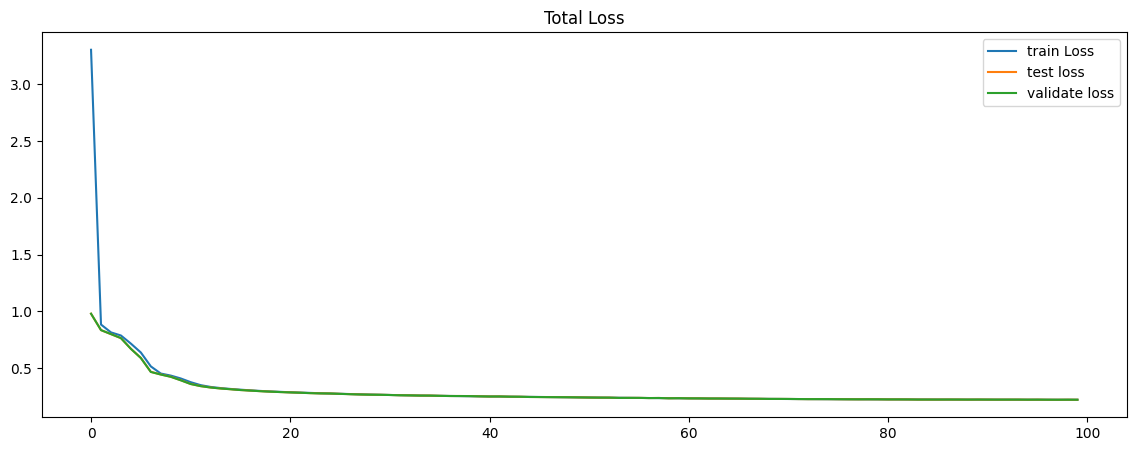

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='train Loss')
plt.plot(test_total_losses, label='test loss')
plt.plot(val_total_losses, label='validate loss')
plt.legend()
plt.title('Total Loss')
plt.show()

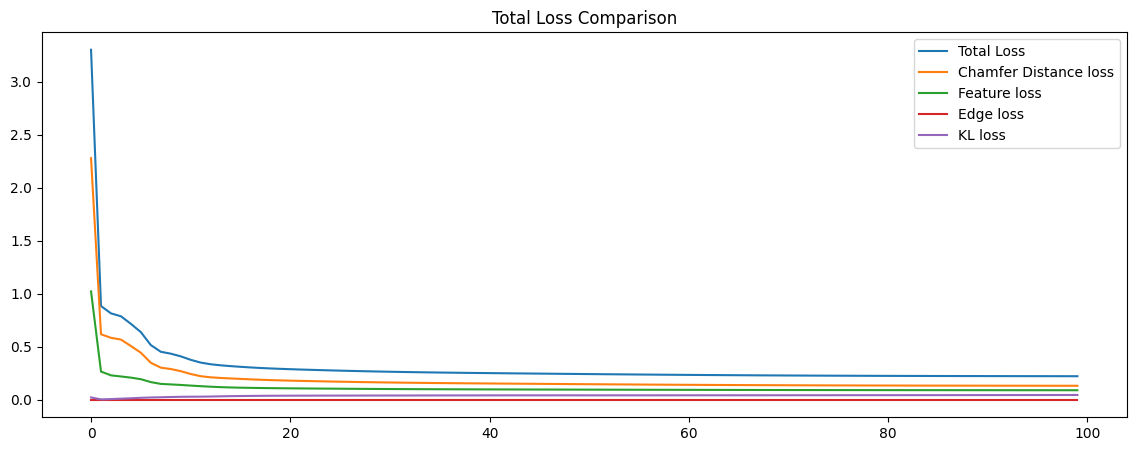

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

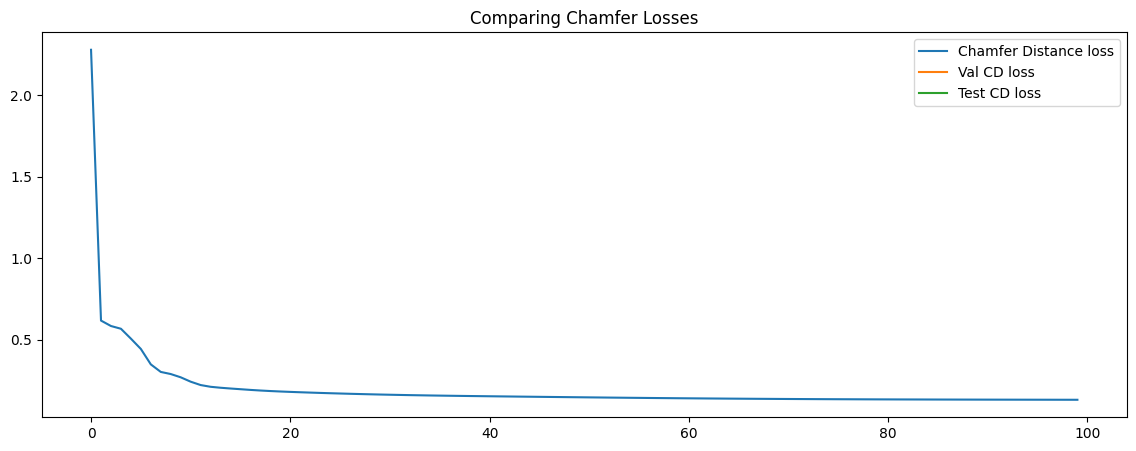

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(val_cd_loss, label='Val CD loss')
plt.plot(test_cd_loss, label='Test CD loss')
plt.legend()
plt.title('Comparing Chamfer Losses')
plt.show()

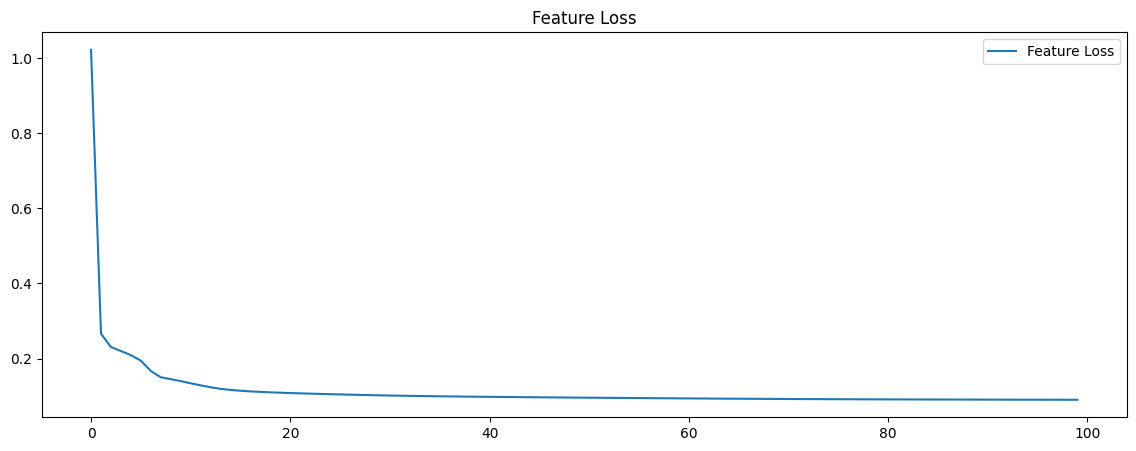

In [20]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()